#  Обнаружение объектов

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
* https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/
* https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

## Задачи для совместного разбора

1\. Рассмотрите простейшую архитектуру для решения задачи object detection и процесс настройки модели.

In [1]:
import torch as th
import torch.nn as nn

In [2]:
imgs = th.rand(size=(16, 3, 100, 100))
bboxes_true = th.rand(size=(16, 4))
labels_true = th.randint(0, 2, size=(16, ))

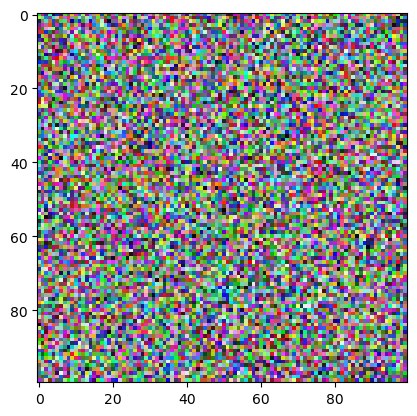

In [3]:
import matplotlib.pyplot as plt

plt.imshow(imgs[0].permute(1, 2, 0))
plt.show()

In [4]:
class Detector(nn.Module):
	def __init__(self):
		super().__init__()
		self.backbone = nn.Sequential(
			nn.Conv2d(3, 64, kernel_size=3),
			nn.ReLU(),
			nn.MaxPool2d(2)
		)

		self.regressor = nn.Sequential(
			nn.Linear(153664, 64),
			nn.ReLU(),
			nn.Linear(64, 4)
		)

		self.classifier = nn.Sequential(
			nn.Linear(153664, 64),
			nn.ReLU(),
			nn.Linear(64, 2)
		)

	def forward(self, X):
		features = self.backbone(X).flatten(start_dim=1)
		bbox = self.regressor(features)
		labels = self.classifier(features)

		return bbox, labels

In [5]:
model = Detector()
bboxes_pred, labels_pred = model(imgs)

In [6]:
bboxes_pred[0], labels_pred[0]

(tensor([ 0.0237,  0.1002,  0.2331, -0.1227], grad_fn=<SelectBackward0>),
 tensor([0.0690, 0.1082], grad_fn=<SelectBackward0>))

In [7]:
mse_criterion = nn.MSELoss()
ce_criterion = nn.CrossEntropyLoss()

In [8]:
loss = (
    0.5*mse_criterion(bboxes_pred, bboxes_true) +
    0.5*ce_criterion(labels_pred, labels_true)
)

## Задачи для самостоятельного решения

<p class='task' id='1'></p>

1\. Напишите функцию `parse_xml`, которая читает xml-файл с разметкой изображения из архива `animals.zip` и возвращает словарь, содержащий три ключа:
```
{
        'raw': # словарь с ключами xmin, ymin, xmax, ymax
        'scaled': # словарь с ключами xmin, ymin, xmax, ymax
        'obj_name': # строка
}
```
В этом словаре `row` - абсолютные значения координат вершин bounding box, а `scaled` - относительные (нормированные на ширину и высоту изображения). Примените функцию к файлу `cat.0.xml` и выведите результат на экран.


- [ ] Проверено на семинаре

In [9]:
import xml.etree.ElementTree as ET
from zipfile import ZipFile

In [10]:
def parse_xml(zip_path, xml_name):
    with ZipFile(zip_path) as z:
        with z.open(xml_name) as f:
            tree = ET.parse(f)
            root = tree.getroot()

            for obj in root.iter('object'):
                size = root.find('size')
                width = int(size.find('width').text)
                height = int(size.find('height').text)
                
                obj = root.find('object')
                obj_name = obj.find('name').text
                
                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)
                
                out = {
                    'raw': {
                        'xmin': xmin,
                        'ymin': ymin,
                        'xmax': xmax,
                        'ymax': ymax
                    },
                    'scaled': {
                        'xmin': xmin / width,
                        'ymin': ymin / height,
                        'xmax': xmax / width,
                        'ymax': ymax / height
                    },
                    'obj_name': obj_name,
                }

                return out

In [11]:
parse_xml('./../data/animals.zip', 'Asirra: cat vs dogs/cat.17.xml')

{'raw': {'xmin': 23.0, 'ymin': 6.0, 'xmax': 438.0, 'ymax': 368.0},
 'scaled': {'xmin': 0.04609218436873747,
  'ymin': 0.016,
  'xmax': 0.8777555110220441,
  'ymax': 0.9813333333333333},
 'obj_name': 'cat'}

<p class='task' id='2'></p>

2\. Опишите датасет `AnimalDetectionDataset` на основе архива `animals.zip`. Реализуйте `__getitem__` таким образом, чтобы он возвращал три элемента: тензор с изображением, словарь с координатами bounding box и метку объекта. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений, преобразование для метки объекта (для кодирования) и флаг, показывающий, нужно ли возвращать исходные или нормированные координаты bounding box.

- [ ] Проверено на семинаре

In [12]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

In [13]:
class AnimalDetectionDataset(Dataset):
    def __init__(self, zip_path, transforms=None, target_transform = None, return_scaled=True):
        self.zip_path = zip_path
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled
        
        with ZipFile(self.zip_path) as z:
            self.file_list = z.namelist()
        
        self.images_path = list(filter(lambda x: x.endswith('.jpg'), self.file_list))
        self.annotations_path = [f.replace('.jpg', '.xml') for f in self.images_path]
    
    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, index):
        with ZipFile(self.zip_path) as z:
            with z.open(self.images_path[index]) as f:
                img = Image.open(f).convert('RGB')
                
            annotation = parse_xml(self.zip_path, self.annotations_path[index])
            
            if self.transforms:
                img = self.transforms(img)
        
            label = self.target_transform(annotation.get('obj_name')) \
                if self.target_transform else \
                annotation.get('obj_name')
            
            out = (
                th.from_numpy(np.array(img)),
                annotation.get('scaled') \
                    if self.return_scaled else \
                    annotation.get('raw'),
                label
            )
            
            return out

<p class='task' id='3'></p>

3\. Создайте объект класса `AnimalDetectionDataset` без применения преобразований и со значением `return_scaled=False`. Напишите функцию `show_image_with_bounding_box` для визуализации изображения с добавлением на него bounding box и подписи объекта. Продемонстрируйте работу функцию на изображении собаки и кошки.

- [ ] Проверено на семинаре

In [14]:
dataset = AnimalDetectionDataset(
    './../data/animals.zip',
    transforms=None,  
    target_transform=None, 
    return_scaled=False,
)
dataset[0]

(tensor([[[203, 164,  87],
          [203, 164,  87],
          [204, 165,  88],
          ...,
          [240, 201, 122],
          [239, 200, 121],
          [238, 199, 120]],
 
         [[203, 164,  87],
          [203, 164,  87],
          [204, 165,  88],
          ...,
          [241, 202, 123],
          [240, 201, 122],
          [238, 199, 120]],
 
         [[203, 164,  87],
          [203, 164,  87],
          [204, 165,  88],
          ...,
          [241, 202, 123],
          [240, 201, 122],
          [239, 200, 121]],
 
         ...,
 
         [[153, 122,  55],
          [153, 122,  55],
          [153, 122,  55],
          ...,
          [  2,   2,   0],
          [  2,   2,   0],
          [  2,   2,   0]],
 
         [[152, 121,  54],
          [152, 121,  54],
          [152, 121,  54],
          ...,
          [  2,   2,   0],
          [  2,   2,   0],
          [  2,   2,   0]],
 
         [[151, 120,  53],
          [151, 120,  53],
          [151, 120,  53],
   

In [15]:
def show_image_with_bounding_box(row):
    img, bbox, label = row

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    rect = plt.Rectangle(
        (bbox['xmin'], bbox['ymin']),
        bbox['xmax'] - bbox['xmin'],
        bbox['ymax'] - bbox['ymin'],
        linewidth=2, edgecolor='g', facecolor='none'
    )
    ax.add_patch(rect)

    plt.text(bbox['xmin'], bbox['ymin'] - 10, label, color='green', fontsize=12, weight='bold')

    plt.show()

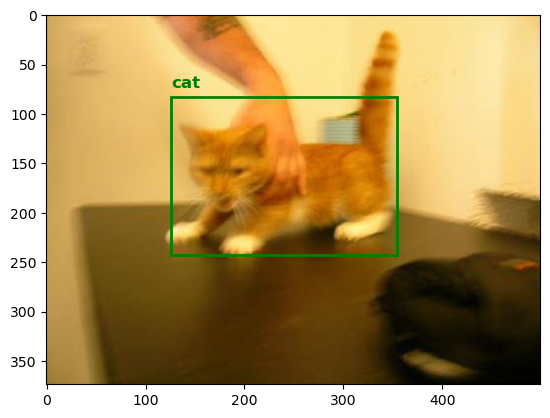

In [16]:
show_image_with_bounding_box(dataset[0])

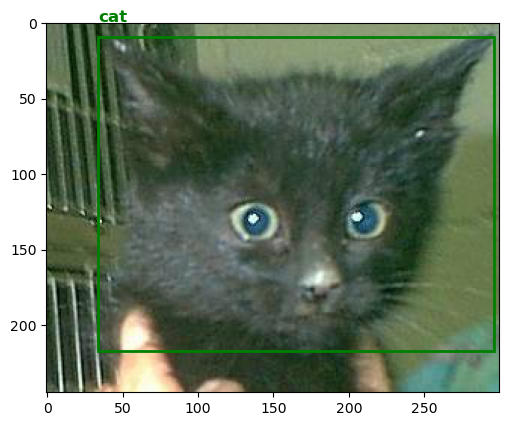

In [17]:
show_image_with_bounding_box(dataset[127])

<p class='task' id='4'></p>

4\. Напишите модель для решения задачи выделения объектов. Реализуйте двухголовую сеть, одна голова которой предсказывает метку объекта (задача классификации), а вторая голова предсказывает 4 координаты вершин bounding box (задача регрессии). В качестве backbone используйте модель resnet50 из пакета `torchvision`.

- [ ] Проверено на семинаре

In [18]:
from torchvision.models import resnet50

In [19]:
class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        
        self.regressor = nn.Sequential(
            nn.Linear(2048 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

        self.classifier = nn.Sequential(
            nn.Linear(2048 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, X):
        features = self.backbone(X).flatten(start_dim=1)
        bbox = self.regressor(features)
        labels = self.classifier(features)

        return bbox, labels

<p class='task' id='5'></p>

5\. Разбейте набор данных на обучающее и валидационное множество. Обучите модель, описанную в задаче 4. При создании датасета не забудьте указать преобразования, соответствующие модели ResNet.

Используйте сумму MSELoss (для расчета ошибки на задаче регрессии) и CrossEntropyLoss (для расчета ошибки на задачи классификации) для настройки весов модели. Для ускорения процесса обучения слои backbone можно заморозить. Во время обучения выводите на экран значения функции потерь на обучающем и валидационном множестве. Используя обученную модель, получите предсказания для изображения кошки и собаки и отрисуйте их. Выполните процедуру, обратную нормализации, чтобы корректно отобразить фотографии.

- [ ] Проверено на семинаре

In [20]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import random_split, DataLoader
from torch import optim

In [21]:
dataset = AnimalDetectionDataset(
    './../data/animals.zip',
    transforms=Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    target_transform=lambda label: 0 if label == 'cat' else 1,
    return_scaled=True
)
dataset_train, dataset_val = random_split(
    dataset, [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))]
)

In [22]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
model = Detector().to(device)
for param in model.backbone.parameters():
    param.requires_grad = True

/home/kekwak/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kekwak/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=4, shuffle=False, num_workers=4)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()

In [24]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_idx, (images, bboxes, labels) in enumerate(train_loader):
        images = images.to(device)
        bboxes_tensor = th.stack(
            [bboxes[key].to(th.float32) for key in ['xmin', 'ymin', 'xmax', 'ymax']], dim=1
        ).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pred_bboxes, pred_labels = model(images)
        
        loss_class = criterion_class(pred_labels, labels)
        loss_bbox = criterion_bbox(pred_bboxes, bboxes_tensor)
        loss = 0.5 * loss_class +  0.5 * loss_bbox

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with th.no_grad():
        for batch_idx, (images, bboxes, labels) in enumerate(val_loader):
            images = images.to(device)
            bboxes_tensor = th.stack(
                [bboxes[key].to(th.float32) for key in ['xmin', 'ymin', 'xmax', 'ymax']], dim=1
            ).to(device)
            labels = labels.to(device)

            pred_bboxes, pred_labels = model(images)
            
            loss_class = criterion_class(pred_labels, labels)
            loss_bbox = criterion_bbox(pred_bboxes, bboxes_tensor)
            loss =  0.5 * loss_class +  0.5 * loss_bbox

            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}')

Epoch 1/10 - Train Loss: 0.1398 - Val Loss: 0.0398
Epoch 2/10 - Train Loss: 0.0474 - Val Loss: 0.0787
Epoch 3/10 - Train Loss: 0.0131 - Val Loss: 0.0389
Epoch 4/10 - Train Loss: 0.0081 - Val Loss: 0.0356
Epoch 5/10 - Train Loss: 0.0051 - Val Loss: 0.0313
Epoch 6/10 - Train Loss: 0.0046 - Val Loss: 0.0343
Epoch 7/10 - Train Loss: 0.0052 - Val Loss: 0.0424
Epoch 8/10 - Train Loss: 0.0034 - Val Loss: 0.0351
Epoch 9/10 - Train Loss: 0.0043 - Val Loss: 0.1037
Epoch 10/10 - Train Loss: 0.0034 - Val Loss: 0.0364


In [25]:
def denormalize(image, mean, std):
    mean = th.tensor(mean).view(3, 1, 1)
    std = th.tensor(std).view(3, 1, 1)
    image = image * std + mean
    return image

def visualize_prediction(image, bbox, label, label_map, mean, std):
    image = denormalize(image, mean, std).permute(1, 2, 0).cpu().numpy()
    image = np.clip(image, 0, 1)

    xmin, ymin, xmax, ymax = bbox
    xmin *= image.shape[1]
    ymin *= image.shape[0]
    xmax *= image.shape[1]
    ymax *= image.shape[0]

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        edgecolor='red', fill=False, linewidth=2
    ))
    plt.title(f'Predicted: {label_map[label]}')
    plt.axis('off')
    plt.show()

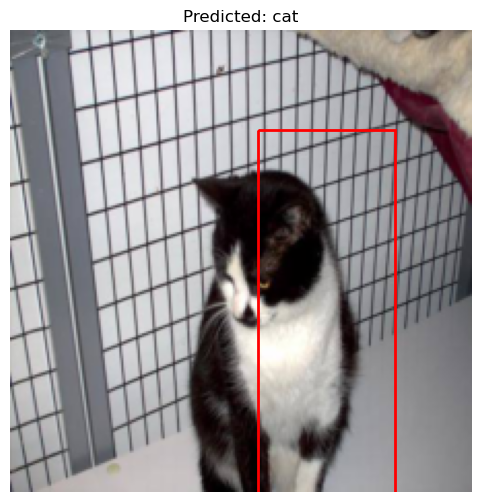

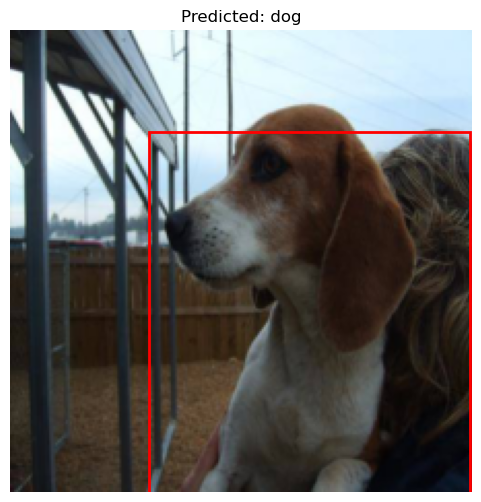

In [26]:
model.eval()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
indices = [107, 1007]

images, predicted_bboxes, predicted_labels = [], [], []
with th.no_grad():
    for idx in indices:
        image, true_bbox, true_label = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)
        
        pred_bboxes, pred_labels = model(image_tensor)
        
        pred_bbox = pred_bboxes[0].cpu().numpy()
        pred_label = pred_labels[0].argmax().item()

        images.append(image)
        predicted_bboxes.append(pred_bbox)
        predicted_labels.append(pred_label)

for image, predicted_bbox, predicted_label in zip(images, predicted_bboxes, predicted_labels):
    visualize_prediction(image, predicted_bbox, predicted_label, {0: 'cat', 1: 'dog'}, mean, std)

<p class='task' id='6'></p>

6\. Найдите в сети несколько изображений котов и собак. Используя любой инструмент для разметки (например, [CVAT](https://www.cvat.ai/)), выделите котов и собак на изображениях. Вставьте скриншот экспортированного файла с разметкой. Используя полученные изображения, визуализируйте разметку и bounding boxes, полученные при помощи модели.

- [ ] Проверено на семинаре

![Снимок экрана 2024-12-02 в 17.28.04.png](<attachment:Снимок экрана 2024-12-02 в 17.28.04.png>)
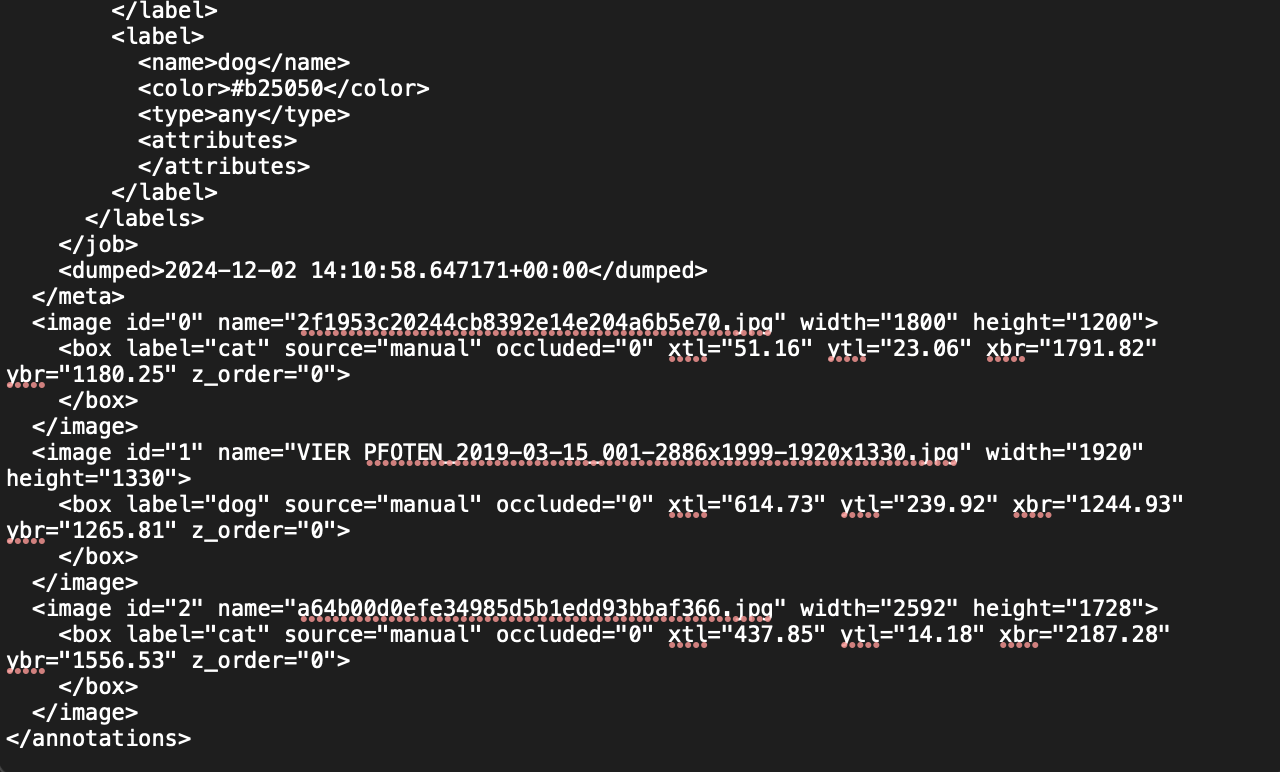

In [27]:
def parse_xml(zip_path, image_path, xml_name):
    with ZipFile(zip_path) as z:
        with z.open(xml_name) as f:
            tree = ET.parse(f)
            root = tree.getroot()

            image_annotation = root.find(f".//image[@name='{image_path.split('/')[-1]}']")

            width = int(image_annotation.attrib['width'])
            height = int(image_annotation.attrib['height'])

            box = image_annotation.find("box")
            xmin = float(box.attrib['xtl'])
            ymin = float(box.attrib['ytl'])
            xmax = float(box.attrib['xbr'])
            ymax = float(box.attrib['ybr'])
            label = box.attrib['label']

            out = {
                'raw': {
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax
                },
                'scaled': {
                    'xmin': xmin / width,
                    'ymin': ymin / height,
                    'xmax': xmax / width,
                    'ymax': ymax / height
                },
                'obj_name': label,
            }

            return out

In [28]:
class AnimalDetectionDataset(Dataset):
    def __init__(self, zip_path, transforms=None, target_transform = None, return_scaled=True):
        self.zip_path = zip_path
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled
        
        with ZipFile(self.zip_path) as z:
            self.file_list = z.namelist()
        
        self.images_path = list(filter(lambda x: x.endswith('.jpg'), self.file_list))
        self.annotations_path = 'cvat-annotations/annotations.xml'
    
    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, index):
        with ZipFile(self.zip_path) as z:
            with z.open(self.images_path[index]) as f:
                img = Image.open(f).convert('RGB')
                
            annotation = parse_xml(self.zip_path, self.images_path[index], self.annotations_path)
            
            if self.transforms:
                img = self.transforms(img)
        
            label = self.target_transform(annotation.get('obj_name')) \
                if self.target_transform else \
                annotation.get('obj_name')
            
            out = (
                th.from_numpy(np.array(img)),
                annotation.get('scaled') \
                    if self.return_scaled else \
                    annotation.get('raw'),
                label
            )
            
            return out

In [29]:
dataset = AnimalDetectionDataset(
    './../data/cvat-annotations.zip',
    transforms=Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    target_transform=lambda label: 0 if label == 'cat' else 1,
    return_scaled=True
)

In [35]:
def visualize_prediction(image, true_bbox, bbox, label, label_map, mean, std):
    image = denormalize(image, mean, std).permute(1, 2, 0).cpu().numpy()
    image = np.clip(image, 0, 1)

    xmin, ymin, xmax, ymax = bbox
    xmin *= image.shape[1]
    ymin *= image.shape[0]
    xmax *= image.shape[1]
    ymax *= image.shape[0]

    xmin_true, ymin_true, xmax_true, ymax_true = true_bbox.values()
    xmin_true *= image.shape[1]
    ymin_true *= image.shape[0]
    xmax_true *= image.shape[1]
    ymax_true *= image.shape[0]

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        edgecolor='red', fill=False, linewidth=1, label='Predicted'
    ))
    plt.gca().add_patch(plt.Rectangle(
        (xmin_true, ymin_true), xmax_true - xmin_true, ymax_true - ymin_true,
        edgecolor='green', fill=False, linewidth=1, label='True'
    ))
    plt.title(f'Predicted: {label_map[label]}')
    plt.legend()
    plt.axis('off')
    plt.show()

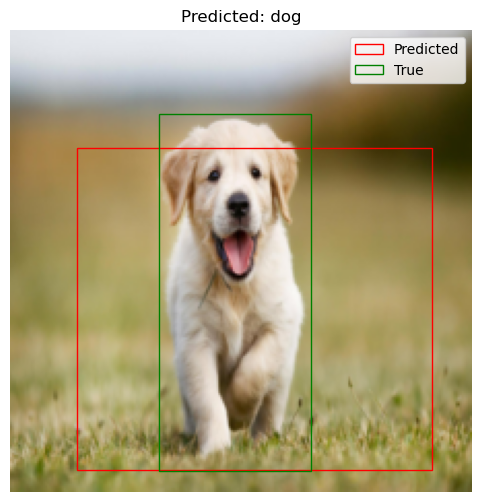

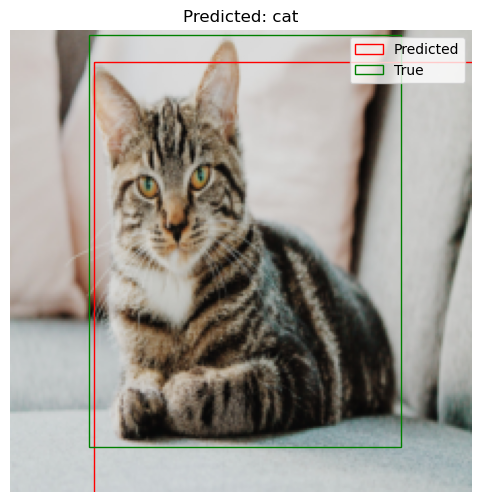

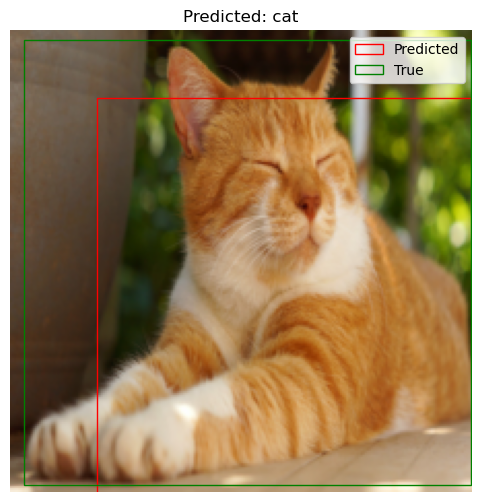

In [36]:
images, true_bboxes, predicted_bboxes, predicted_labels = [], [], [], []
with th.no_grad():
    for idx in range(len(dataset)):
        image, true_bbox, true_label = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)
        
        pred_bboxes, pred_labels = model(image_tensor)
        
        pred_bbox = pred_bboxes[0].cpu().numpy()
        pred_label = pred_labels[0].argmax().item()

        images.append(image)
        true_bboxes.append(true_bbox)
        predicted_bboxes.append(pred_bbox)
        predicted_labels.append(pred_label)

for image, true_bbox, predicted_bbox, predicted_label in zip(images, true_bboxes, predicted_bboxes, predicted_labels):
    visualize_prediction(image, true_bbox, predicted_bbox, predicted_label, {0: 'cat', 1: 'dog'}, mean, std)